# Chapter 9: DL for IoT Healthcare 

# Use Case 1: Remote Chronic Disease Management

# Model: LSTM

# Step 1: Download Dataset

The first use case will work on ECG dataset. Please download the dataset from https://physionet.org/pn3/challenge/2017/ download the training dataset into your preferred folder and unzip it. In our we conidered dataset/ECG folder.

# Step 2: Dataset Exploration

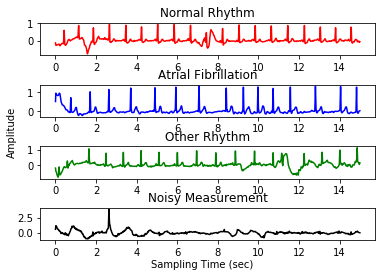

In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
 #Import to a python dictionary
Class1 = scipy.io.loadmat('dataset/ECG/A00001.mat') # Normal Rhythm
Class2 = scipy.io.loadmat('dataset/ECG/A00004.mat') # Atrial Fibrillation
Class3 = scipy.io.loadmat('dataset/ECG/A00008.mat') # Other Rhythm
Class4 = scipy.io.loadmat('dataset/ECG/A00022.mat') # Noisy measurement

# Scale Conversion (mV)
y1 = Class1["val"]/1000
y2 = Class2["val"]/1000
y3 = Class3["val"]/1000
y4 = Class4["val"]/1000

x =np.arange(0, 15, 1/300) # Number of sampling times to be displayed based on 300Hz sampling rate 
l=len(x)
# This is to show plot 
%matplotlib inline
# Plotting
fig, ax = plt.subplots(4, 1)
ax[0].plot(x, y1[0, 0:l], 'r') #row=0, col=0

ax[1].plot(x, y2[0, 0:l], 'b') #row=1, col=0

ax[2].plot(x, y3[0, 0:l], 'g') #row=0, col=1
ax[3].plot(x, y4[0, 0:l], 'k') #row=1, col=1
plt.subplots_adjust(hspace=.9)
fig.text(.5, 0.04, 'Sampling Time (sec)', ha='center', va='center')
fig.text(0.06, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical')
ax[0].set_title('Normal Rhythm')
ax[1].set_title('Atrial Fibrillation')
ax[2].set_title('Other Rhythm')
ax[3].set_title('Noisy Measurement')
plt.savefig('ecg_data_exploration.png', dpi=300)
plt.show()


# Step 2: Pre-processing

The dataset we got are pre-processed as we can see from the data exploration above. Lets move to next step.

# Step 3: Model Training and Validation 

In [4]:
import numpy
import matplotlib.pyplot as plt
import pandas
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import pandas as pd
import scipy.io as sio
from os import listdir
from os.path import isfile, join
import numpy as np
from keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.callbacks import ModelCheckpoint
import seaborn as sn

#Number of classes: [normal rhythm, atrial fibrillation, other rhythm, noisy measurements]
number_of_classes = 4 

# Function change format: from boolean arrays to decimal arrays
def change_format(x): 
    answer = np.zeros((np.shape(x)[0]))
    for i in range(np.shape(x)[0]):
        max_value = max(x[i, :])
        max_index = list(x[i, :]).index(max_value)
        answer[i] = max_index
    return answer.astype(np.int)

Using TensorFlow backend.


# Data loading and preparing for the Model

In [5]:
dataset_path = 'dataset/ECG/'
# Read all files from the folder linked with measurements, means start with 'A' 
all_files = [f for f in listdir(dataset_path) if (isfile(join(dataset_path, f)) and f[0] == 'A')]
bats = [f for f in all_files if f[7] == 'm']
input_size_threshold = 9000 
mats = [f for f in bats if (np.shape(sio.loadmat(dataset_path + f)['val'])[1] >= input_size_threshold)]
check = np.shape(sio.loadmat(dataset_path + mats[0])['val'])[1]
X = np.zeros((len(mats), check))
for i in range(len(mats)):
    X[i, :] = sio.loadmat(dataset_path + mats[i])['val'][0, :input_size_threshold]

target_train = np.zeros((len(mats), 1))
Train_data = pd.read_csv(dataset_path + 'REFERENCE.csv', sep=',', header=None, names=None)
for i in range(len(mats)):
    if Train_data.loc[Train_data[0] == mats[i][:6], 1].values == 'N':
        target_train[i] = 0
    elif Train_data.loc[Train_data[0] == mats[i][:6], 1].values == 'A':
        target_train[i] = 1
    elif Train_data.loc[Train_data[0] == mats[i][:6], 1].values == 'O':
        target_train[i] = 2
    else:
        target_train[i] = 3

Label_set = np.zeros((len(mats), number_of_classes))
for i in range(np.shape(target_train)[0]):
    dummy = np.zeros((number_of_classes))
    dummy[int(target_train[i])] = 1
    Label_set[i, :] = dummy


#Training data preparation
train_len = 0.9 # Fraction of the dataset for training 
X_train = X[:int(train_len*len(mats)), :]
Y_train = Label_set[:int(train_len*len(mats)), :]
X_val = X[int(train_len*len(mats)):, :]
Y_val = Label_set[int(train_len*len(mats)):, :]

# reshape input to be [samples, time steps, features]
X_train = numpy.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = numpy.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))


The number of total ECG samples is  7561


# LSTM DL model cration

In [6]:
# LSTM DL model cration 
batch_size = 32
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(1, check)))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(number_of_classes, activation='softmax'))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Model Compilation, Training and Validation

In [ ]:
# Logging through Tensorbard
tensorboard = TensorBoard(log_dir='./logs_lstm',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

# Model compilation 
#early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=50, verbose=1, mode='auto')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='trained-models-lstm/Best_model.h5', monitor='val_acc', verbose=1, save_best_only=True)
# Model fitting
model.fit(X_train, Y_train, epochs=500, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=2, shuffle=False, callbacks=[checkpointer, tensorboard])
# Model validation
predictions = model.predict(X_val)
score = accuracy_score(change_format(Y_val), change_format(predictions))
print('Last epoch\'s validation score is ', score)


Instructions for updating:
Use tf.cast instead.
Train on 6804 samples, validate on 757 samples
Epoch 1/500


# Result storing and Ploting 

In [ ]:
# Confusion Matrix generation and plotting
confusion_matrix=pd.DataFrame(confusion_matrix(change_format(Y_val), change_format(predictions)), index = [i for i in "0123"],
                  columns = [i for i in "0123"])
confusion_matrix_normalised= confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

print(confusion_matrix)
print(confusion_matrix_normalised)
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix_normalised, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.savefig('figures/confusion-matrix-lstm-ecg.png', dpi=300)
plt.show()